In [2]:
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders


2024-04-26 22:37:45.970680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 22:37:46.542645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
"""input_folder = r'/mnt/z/GP2-Data/MRIBRAIN/Train_Test_Val'
output_folder = r'/mnt/z/GP2-Data/MRIBRAIN/SplitData'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None) # default values"""


In [25]:
"""import os
import shutil

input_folder = r'/mnt/z/GP2-Data/MRIBRAIN/brain tumor 1'
output_folder = r'/mnt/z/GP2-Data/MRIBRAIN/Train_Test_Val'

# Define your own function to identify the class from the filename
def get_class_from_filename(filename):
    # Implement your own logic here
    if int(np.array(h5py.File("/mnt/z/GP2-Data/MRIBRAIN/brain tumor 1/"+str(filename), 'r')['cjdata']['label'])) == 1:
        return 'meningioma'
    elif int(np.array(h5py.File("/mnt/z/GP2-Data/MRIBRAIN/brain tumor 1/"+str(filename), 'r')['cjdata']['label'])) == 2:
        return 'glioma'
    elif int(np.array(h5py.File("/mnt/z/GP2-Data/MRIBRAIN/brain tumor 1/"+str(filename), 'r')['cjdata']['label'])) == 3:
        return 'pituitary tumor'
    else:
        return 'unknown'
    pass

# Create class directories in the output folder
for filename in os.listdir(input_folder):
    class_name = get_class_from_filename(filename)
    class_dir = os.path.join(output_folder, class_name)
    os.makedirs(class_dir, exist_ok=True)
    shutil.move(os.path.join(input_folder, filename), class_dir)"""

In [3]:
def load_mat_files(dataset_path, image_size=(224, 224)):
    all_images = []
    all_masks = []  # This will hold the tumor masks

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".mat"):
                file_path = os.path.join(root, file)
                with h5py.File(file_path, 'r') as f:
                    # Direct access to the 'cjdata' group and its contents
                    image_data = np.array(f['cjdata']['image'])
                    mask_data = np.array(f['cjdata']['tumorMask'])  # Extract the tumor mask

                    # Resizing the image and mask to the desired size
                    image = cv2.resize(image_data, image_size, interpolation=cv2.INTER_AREA)
                    mask = cv2.resize(mask_data, image_size, interpolation=cv2.INTER_NEAREST)  # Use nearest interpolation for masks to avoid introducing new values
                    
                    # Normalize image data and add a channel dimension
                    image = np.expand_dims(image, axis=-1) / 255.0
                    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension to mask
                    
                    all_images.append(image)
                    all_masks.append(mask)

    return np.array(all_images), np.array(all_masks)

images_train, masks_train = load_mat_files("/mnt/z/GP2-Data/MRIBRAIN/SplitData/train")
images_val, masks_val = load_mat_files("/mnt/z/GP2-Data/MRIBRAIN/SplitData/val")
print("Loaded and resized images and masks with channel dimension:", images_train.shape, masks_train.shape)
print("Loaded and resized images and masks with channel dimension:", images_val.shape, masks_val.shape)


Loaded and resized images and masks with channel dimension: (2143, 224, 224, 1) (2143, 224, 224, 1)
Loaded and resized images and masks with channel dimension: (458, 224, 224, 1) (458, 224, 224, 1)


In [4]:
images_val.shape[1:]

(224, 224, 1)

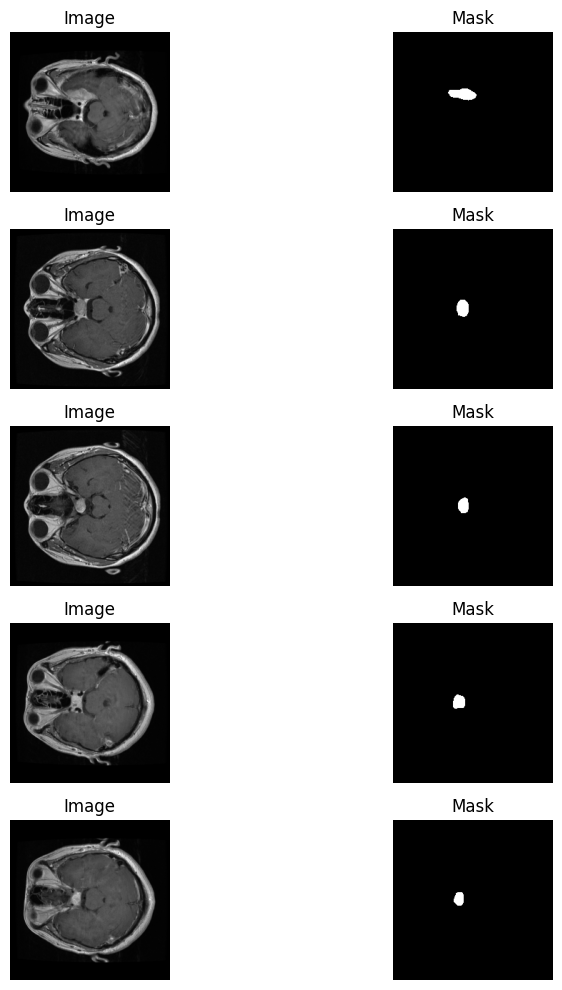

In [5]:

def show_images_masks(images, masks, number_to_show=10):
    number_to_show = min(number_to_show, len(images))  # Ensure we don't exceed the number of available images
    
    plt.figure(figsize=(10, 2 * number_to_show))  # Adjust the size as necessary
    for i in range(number_to_show):
        plt.subplot(number_to_show, 2, 2 * i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title('Image')
        plt.axis('off')
        
        plt.subplot(number_to_show, 2, 2 * i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage: Assuming 'mat_images' and 'mat_masks' are loaded using the previous function
show_images_masks(images_train, masks_train, number_to_show=5)  # Show 5 image-mask pairs


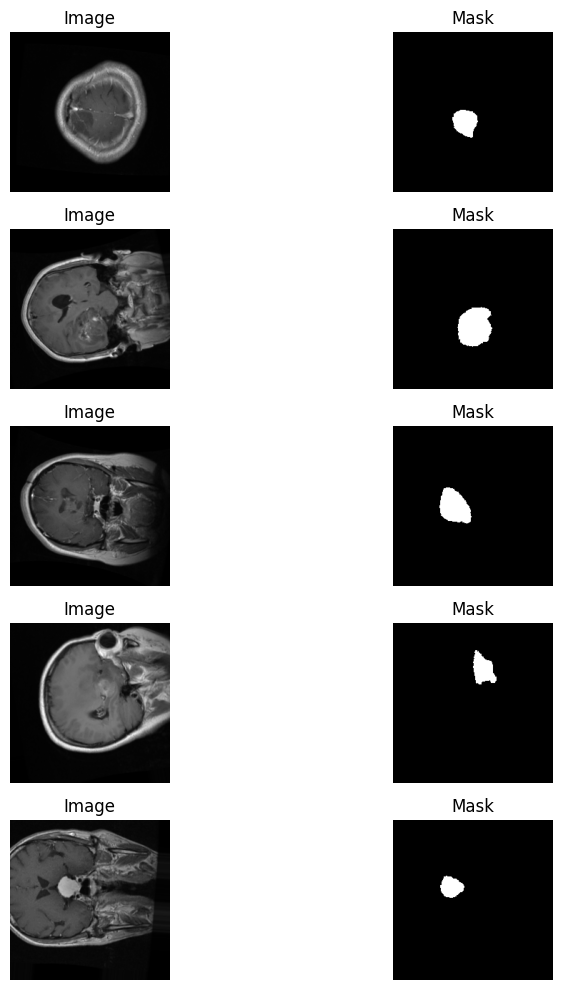

In [6]:

def augment_data(images, masks, batch_size):
    # Create image data augmentation generator
    image_data_gen_args = dict(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.05,
                               zoom_range=0.1,
                               fill_mode='nearest')
    image_datagen = ImageDataGenerator(**image_data_gen_args)

    # Create mask data augmentation generator
    mask_data_gen_args = dict(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.05,
                              zoom_range=0.1,
                              fill_mode='nearest',
                              preprocessing_function=lambda x: np.where(x > 0, 1, 0))  # Ensure mask only has 0s and 1s
    mask_datagen = ImageDataGenerator(**mask_data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed,)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    # Combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    return train_generator


batch_size = 32  
augmented_data_generator = augment_data(images_train, masks_train, batch_size)

# To test and visualize augmented data 
augmented_images, augmented_masks = next(augmented_data_generator)
show_images_masks(augmented_images, augmented_masks, number_to_show=5)


In [8]:
# Define the U-Net model architecture
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    p = Dropout(0.3)(p)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor])
    x = Dropout(0.3)(x)
    x = conv_block(x, num_filters)
    return x

def Segmentation_unet(input_shape):
    inputs = Input(input_shape)
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, x4, 512)
    d2 = decoder_block(d1, x3, 256)
    d3 = decoder_block(d2, x2, 128)
    d4 = decoder_block(d3, x1, 64)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the dice coefficient for model evaluation
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [9]:
# Create the model
model = Segmentation_unet(images_train.shape[1:])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=[dice_coefficient])

# Define callbacks for this fold
checkpoint_cb = ModelCheckpoint(f"non_fold_unet.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.1, patience=5)

# Augment the data
train_generator = augment_data(images_train, masks_train, 16)

val_generator=augment_data(images_val,masks_val,16)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(images_train) // 16,
    validation_data=val_generator,
    validation_steps=len(images_val)// 16,
    epochs=60,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Clear session to free up GPU memory
tf.keras.backend.clear_session()


2024-04-26 22:40:43.811926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:40:44.120005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:40:44.120065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:40:44.123337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 22:40:44.123407: I tensorflow/compile

Epoch 1/60


2024-04-26 22:40:58.744039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-26 22:40:59.522763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-26 22:40:59.962448: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-26 22:41:04.124514: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 22:41:05.520766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged 

133/133 [==============================] - ETA: 0s - loss: 0.4384 - dice_coefficient: 0.0341

/home/ubo/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 97s 557ms/step - loss: 0.4384 - dice_coefficient: 0.0341 - val_loss: 0.6505 - val_dice_coefficient: 0.0349 - lr: 1.0000e-04
Epoch 2/60


2024-04-26 22:42:36.307684: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 22:42:38.767658: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 22:42:42.099610: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-26 22:42:43.108491: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

133/133 [==============================] - 87s 568ms/step - loss: 0.2203 - dice_coefficient: 0.0343 - val_loss: 0.5870 - val_dice_coefficient: 0.0345 - lr: 1.0000e-04
Epoch 3/60
133/133 [==============================] - 73s 546ms/step - loss: 0.1751 - dice_coefficient: 0.0417 - val_loss: 0.4469 - val_dice_coefficient: 0.0361 - lr: 1.0000e-04
Epoch 4/60
133/133 [==============================] - 74s 556ms/step - loss: 0.1458 - dice_coefficient: 0.0640 - val_loss: 0.1951 - val_dice_coefficient: 0.0323 - lr: 1.0000e-04
Epoch 5/60
133/133 [==============================] - 72s 545ms/step - loss: 0.1219 - dice_coefficient: 0.1008 - val_loss: 0.1236 - val_dice_coefficient: 0.0428 - lr: 1.0000e-04
Epoch 6/60
133/133 [==============================] - 73s 546ms/step - loss: 0.1029 - dice_coefficient: 0.1372 - val_loss: 0.0941 - val_dice_coefficient: 0.1083 - lr: 1.0000e-04
Epoch 7/60
133/133 [==============================] - 72s 545ms/step - loss: 0.0882 - dice_coefficient: 0.1725 - val_loss

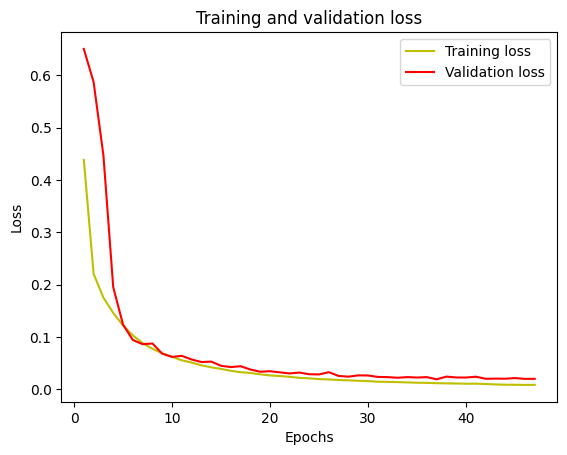

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

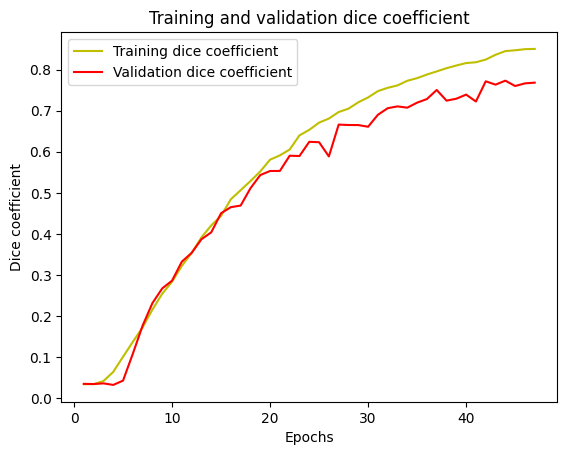

In [11]:
iou_score_ = history.history['dice_coefficient']
val_iou_score_ = history.history['val_dice_coefficient']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, iou_score_, 'y', label='Training dice coefficient')
plt.plot(epochs, val_iou_score_, 'r', label='Validation dice coefficient')
plt.title('Training and validation dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice coefficient')
plt.legend()
plt.show()